# Project Work, Part 3 - Data Quality
## 1. Introduction
This project involves analyzing data in a Jupyter Notebook and creating a multi-page online app with Streamlit, with all work and code shared on GitHub. AI tools (e.g., ChatGPT) were utilized during the project to clarify requirements and to gain a deeper understanding of the technologies used.

In [46]:
import requests 
import pandas as pd

In [47]:
data = {
    "price_area": ["NO1", "NO2", "NO3", "NO4", "NO5"],
    "city": ["Oslo", "Kristiansand", "Trondheim", "Tromsø", "Bergen"],
    "latitude": [59.9127, 58.1467, 63.4305, 69.6489, 60.393],
    "longitude": [10.7461, 7.9956, 10.3951, 18.9551, 5.3242]
}

df = pd.DataFrame(data)
print(df)

  price_area          city  latitude  longitude
0        NO1          Oslo   59.9127    10.7461
1        NO2  Kristiansand   58.1467     7.9956
2        NO3     Trondheim   63.4305    10.3951
3        NO4        Tromsø   69.6489    18.9551
4        NO5        Bergen   60.3930     5.3242


In [48]:
def get_weather_data(lat, lon, year):
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": f"{year}-01-01",
        "end_date": f"{year}-12-31",
        "hourly": ["temperature_2m", "precipitation", "windspeed_10m", "wind_gusts_10m", "wind_direction_10m"],  # example variables
        "timezone": "Europe/Oslo"
    }
    response = requests.get(url, params=params)
    data = response.json()
    df = pd.DataFrame(data["hourly"])
    df = df.rename(columns={'temperature_2m': 'temperature_2m (°C)', 'windspeed_10m': 'wind_speed_10m (m/s)', 
                             'precipitation': 'precipitation (mm)','wind_gusts_10m': 'wind_gusts_10m (m/s)', 
                             'wind_direction_10m': 'wind_direction_10m (°)'})
    return df

bergen_lat = 60.39
bergen_lon = 5.32

df_bergen_2019 = get_weather_data(bergen_lat, bergen_lon, 2019)
df_bergen_2019.head()


,time,temperature_2m (°C),precipitation (mm),wind_speed_10m (m/s),wind_gusts_10m (m/s),wind_direction_10m (°)
0,2019-01-01T00:00,5.7,0.7,37.0,99.7,263
1,2019-01-01T01:00,5.8,0.2,41.0,107.3,278
2,2019-01-01T02:00,6.1,0.7,42.0,112.0,286
3,2019-01-01T03:00,6.3,0.5,40.9,105.8,298
4,2019-01-01T04:00,5.8,1.1,41.2,110.2,315


In [50]:
df_bergen_2019.shape

(8760, 6)

## Outliers and Anomalies:

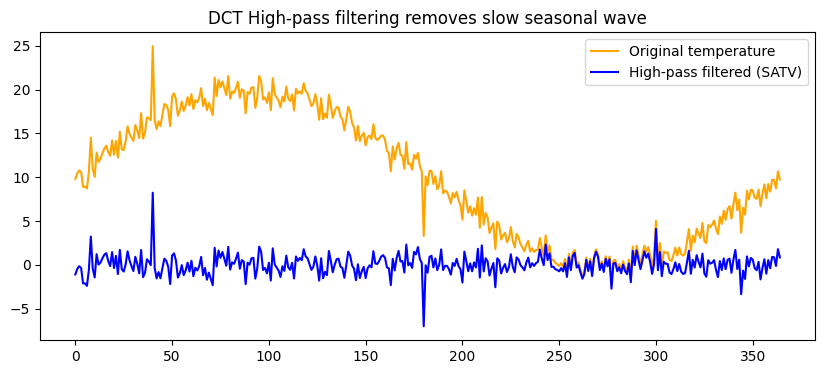

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct

# Simulated temperature signal: seasonal + daily noise + few spikes
t = np.arange(0, 365)               # days in a year
seasonal = 10 + 10*np.sin(2*np.pi*t/365)  # smooth yearly sine
short_term = np.random.normal(0, 1, len(t))
spikes = np.zeros(len(t)); spikes[[40, 180, 300]] = [8, -7, 6]  # anomalies
temp = seasonal + short_term + spikes

# --- Apply DCT ---
dct_coef = dct(temp, norm='ortho')

# Frequency cutoff: remove lower 10 coefficients (slow trend)
cutoff = 10
dct_highpass = np.copy(dct_coef)
dct_highpass[:cutoff] = 0

# Inverse DCT : seasonally adjusted variation
satv = idct(dct_highpass, norm='ortho')

plt.figure(figsize=(10,4))
plt.plot(t, temp, label='Original temperature', color='orange')
plt.plot(t, satv, label='High‑pass filtered (SATV)', color='blue')
plt.title("DCT High‑pass filtering removes slow seasonal wave")
plt.legend()
plt.show()

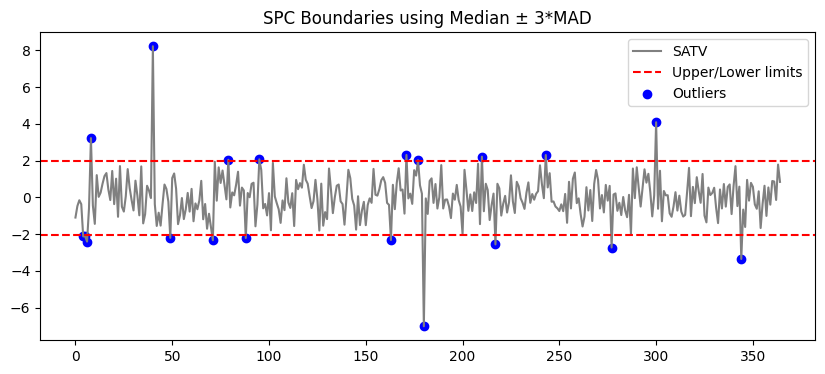

In [55]:
# Robust statistics
median = np.median(satv)
mad = np.median(np.abs(satv - median))

# Choose k (number of MADs)
k = 3
upper = median + k*mad
lower = median - k*mad

# Detect points outside limits
outlier_mask = (satv > upper) | (satv < lower)

plt.figure(figsize=(10,4))
plt.plot(t, satv, label='SATV', color='gray')
plt.axhline(upper, color='red', linestyle='--', label='Upper/Lower limits')
plt.axhline(lower, color='red', linestyle='--')
plt.scatter(t[outlier_mask], satv[outlier_mask], color='blue', label='Outliers')
plt.title("SPC Boundaries using Median ± 3*MAD")
plt.legend()
plt.show()

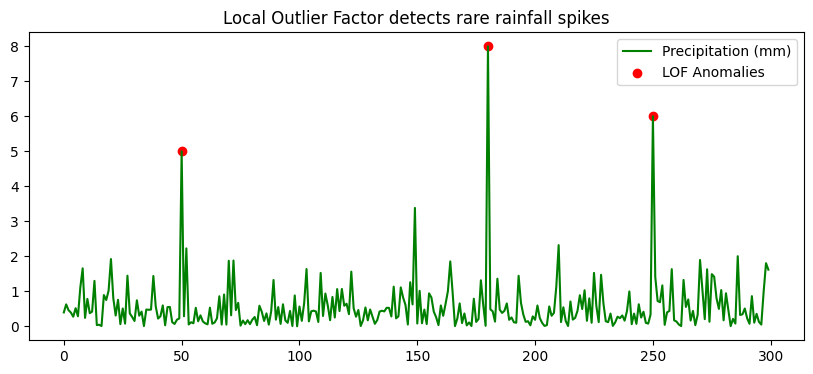

In [58]:
from sklearn.neighbors import LocalOutlierFactor

# Synthetic precipitation series
np.random.seed(0)
precip = np.random.exponential(scale=0.5, size=300)   # mostly small values
precip[[50, 180, 250]] = [5, 8, 6]                    # extreme spikes

# LOF model
lof = LocalOutlierFactor(contamination=0.01)  # ~1% anomalies
labels = lof.fit_predict(precip.reshape(-1,1))
anomaly_mask = labels == -1

plt.figure(figsize=(10,4))
plt.plot(precip, label='Precipitation (mm)', color='green')
plt.scatter(np.where(anomaly_mask)[0], precip[anomaly_mask],
            color='red', label='LOF Anomalies')
plt.title("Local Outlier Factor detects rare rainfall spikes")
plt.legend()
plt.show()